# Сканер документов

1. Прочитаем изображение
2. Определим границы. Для этого переводим изображением в оттенки серого и убираем шум небольшим размытием.
3. Находим границы документа в изображении.
4. Идентифицикация и получение границ документа: соотнесём каждую пару координат с ближайшим углом и рассчитаем размеры документа.
5. Применим перспективное преобразование: переведём полученную интересующую нас область в нужную перспективу.
6. Переведём изображение в черно-белое или увеличеним контраст.


In [1]:
# импортирование необходимых библиотек
import numpy as np
import cv2
import imutils

In [2]:
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
args_image = '/content/drive/MyDrive/Colab Notebooks/ch.png'

In [5]:
# Прочитать изображение
image = cv2.imread(args_image)
orig = image.copy()

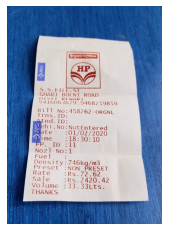

In [6]:
# Выводим
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
# конвертация изображения в градации серого. Это уберёт цветовой шум
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [8]:
# размытие картинки, чтобы убрать высокочастотный шум 
# это помогает определить контур в сером изображении
grayImageBlur = cv2.blur(grayImage,(3,3))

In [9]:
# теперь производим определение границы по методу Canny
edgedImage = cv2.Canny(grayImageBlur, 100, 300, 3)

В оттенках серого:



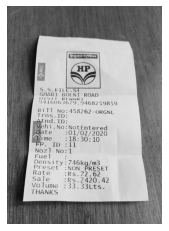

Размытое:



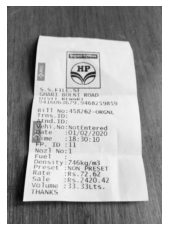

С определенными границами:



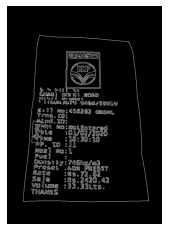

In [10]:
print ("В оттенках серого:\n")
plt.imshow(grayImage, cmap='gray')
plt.axis('off')
plt.show()

print ("Размытое:\n")
plt.imshow(grayImageBlur, cmap='gray')
plt.axis('off')
plt.show()

print ("С определенными границами:\n")
plt.imshow(edgedImage, cmap='gray')
plt.axis('off')
plt.show()

Мы конвертировали цветное изображение в серое, чтобы уменьшить любой цветовой шум, у цветного изображения глубина 3 (по единице на каждый цвет из RGB), в то время как у серого цвета глубина 1. Затем мы применяем функцию blur, чтобы размыть изображение с фильтром (3,3). Размытие уменьшает любой высокочастотный шум и упрощает определение контуров.

Теперь применим алгоритм определения границ Canny, чтобы найти контуры на размытом изображении. Это один из самых популярных алгоритмов для определения широкого диапазона границ в изображениях (этот метод еще называют оптимальным детектором).

In [11]:
# найти контуры на обрезанном изображении, рационально организовать область 
# оставить только большие варианты 
allContours = cv2.findContours(edgedImage.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
allContours = imutils.grab_contours(allContours)

In [12]:
# сортировка контуров области по уменьшению и сохранение топ-1
allContours = sorted(allContours, key=cv2.contourArea, reverse=True)[:1]

In [13]:
# aппроксимация контура
perimeter = cv2.arcLength(allContours[0], True) 
ROIdimensions = cv2.approxPolyDP(allContours[0], 0.02*perimeter, True)

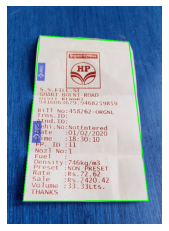

In [14]:
# показать контуры на изображении
cv2.drawContours(image, [ROIdimensions], -1, (0,255,0), 2)
plt.imshow(image)
plt.axis('off')
plt.show()

Оставляем контур с максимальной областью и отбрасываем остальные варианты. Рассматривая изображение с границами, отображенными в предыдущем шаге, мы можем чётко увидеть, что границы документа очерчивают максимальную целостную область. Вместо множества итераций по каждому контуру и сохранению экстремумов, мы просто проверяем область и сохраняем ту, у которой максимальная площадь. Это экономит нам много ресурсов. Если мы заранее знаем количество углов в нашем документе, тогда мы можем использовать такой метод проверки и рассчитывать на хорошие результаты. 

Тут мы использовали парочку функций CV2, таких как `findContours` — для получения всех контуров в обрезанном изображении, `contourArea` —  для получения области, замкнутой контуром координат и `arcLength`. Мы сохранили координаты контуров, чтобы пользоваться ими дальше для обрезки необходимой нам области документа с изображения.

In [15]:
# изменение массива координат
ROIdimensions = ROIdimensions.reshape(4,2)

In [16]:
# список удержания координат ROI
rect = np.zeros((4,2), dtype='float32')

In [17]:
# наименьшая сумма будет у верхнего левого угла, 
# наибольшая — у нижнего правого угла
s = np.sum(ROIdimensions, axis=1)
rect[0] = ROIdimensions[np.argmin(s)]
rect[2] = ROIdimensions[np.argmax(s)]

In [18]:
# верх-право будет с минимальной разницей
# низ-лево будет иметь максимальную разницу
diff = np.diff(ROIdimensions, axis=1)
rect[1] = ROIdimensions[np.argmin(diff)]
rect[3] = ROIdimensions[np.argmax(diff)]

In [19]:
# верх-лево, верх-право, низ-право, низ-лево
(tl, tr, br, bl) = rect

In [20]:
# вычислить ширину ROI
widthA = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2 )
widthB = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2 )
maxWidth = max(int(widthA), int(widthB))

In [21]:
# вычислить высоту ROI
heightA = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2 )
heightB = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2 )
maxHeight = max(int(heightA), int(heightB))

Теперь у нас есть координаты 4 углов документа, мы будем соотносить координаты с углами, а затем расположим их в определённом порядке. 

Поясню основы: изображение состоит из пикселей разного значения (интенсивность цвета). Для цветных изображений у нас будет 3 пикселя значения для точки, а для серого изображения у нас будет один пиксель. Итак, размер изображения — это матрица с первым элементом высоты, вторым — ширины и третьим — глубины цвета, которая обычно равна 3 для цветного изображения и 1 для серого. Итак, мы можем сказать, что для серого изображения у нас будет только два измерения  —  высота и ширина.

Каждый из 4-х углов изображения может быть идентифицирован с его пиксельными координатами как точка на плоскости X-Y. Пиксели изображения начинаются сверху слева. Принимая, что h представляет высоту, а w — ширину, форма изображения будет определяться (h, w, d), где d — это глубина, на которую можно не обращать внимания в случае с серым изображением (h,w).

Верхний левый угол изображения будет иметь координаты (0,0), значит, мы можем сказать, что высота и ширина будут наименьшими среди данных 4-х пар координат. 
Верхний правый угол изображения будет иметь минимальное значение высоты, но максимальное по ширине. В идеале это будет (0,w).
Нижний левый угловой пиксель изображения будет находиться по диагонали напротив верхнего правого. Он должен быть (h,0), т.е. иметь максимальное значение высоты, но минимальное по ширине. 
Нижний правый угол изображения будет иметь максимальное значение по высоте и ширине одновременно.
Применяя описанные параметры 4 углов, мы можем сделать вывод, что верхний левый угол будет иметь наименьшую сумму, в то время как нижняя правая точка будет иметь максимальную сумму среди 4-х точек с координатами. Верхняя правая точка будет иметь минимальную разницу, в то время как нижний левый угол будет иметь наибольшую разницу среди 4 точек с координатами. 

Применяя это рассуждение, мы можем определить, какие координаты к какому из углов ближе. Мы создали список и захватили контур, т.е. координаты ROI (Region of Interest — области интереса) для того, чтобы первая запись в списке была о верхней левой точке, вторая — о правой верхней, третья — о правой нижней и 4-я — о нижней слева. В принципе, направление по часовой стрелке и начинается с левого верхнего угла. 

Мы рассчитали ширину и высоту изображения во многом так, как мы вычисляем расстояние между 2 точками на плоскости X-Y. 

In [22]:
# набор итоговых точек для обзора всего документа
# размер нового изображения
dst = np.array([
    [0,0],
    [maxWidth-1, 0],
    [maxWidth-1, maxHeight-1],
    [0, maxHeight-1]], dtype='float32')

In [23]:
# вычислить матрицу перспективного преобразования и применить её
transformMatrix = cv2.getPerspectiveTransform(rect, dst)

In [24]:
# преобразовать ROI
scan = cv2.warpPerspective(orig, transformMatrix, (maxWidth, maxHeight))

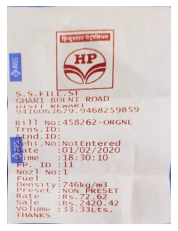

In [25]:
plt.imshow(scan, cmap='gray')
plt.axis('off')
plt.show()

Теперь у нас есть размеры нашей ROI, и мы собираем набор итоговых точек, чтобы получить вид всего изображения сверху. Снова, давайте определим точки в том же порядке, что и раньше, т.е. верх-лево, верх-право, низ-право, низ-лево. Здесь важен порядок, и он должен быть совместим с порядком того, в каких координатах ROI сохранена наша область. Причина в том, что мы будем извлекать ROI из изображения и преобразовывать её по новым размерам.

Применив функцию `getPerspectiveTransform`, мы рассчитали матрицу, которая будет преобразовывать нашу ROI в итоговые размеры, т.е. целостное изображение нашего документа. Для этого нам нужны координаты ROI и итоговой матрицы. Далее мы извлекли площадь ROI из изображения и применили эту трансформацию на полученной области, чтобы получить вид всего нашего документа целиком. Тут мы применили функцию `warpPerspective`.

Несмотря на то, что документ был сфотографирован под углом, мы смогли получить правильную перспективу, применив матрицу преобразования на выделенной области. Итоговый результат на самом деле выглядит хорошо. 

В конце мы можем подготовить изображение для отображения результата. В этом шаге мы применим некоторые действия по пост-обработке, чтобы улучшить внешний вид нашего отсканированного документа: сделаем сканчерно-белым и увеличенным контрастом.

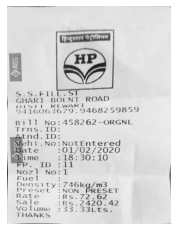

In [27]:
# конвертация в серый
scanGray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
plt.imshow(scanGray, cmap='gray')
plt.axis('off')
plt.show()

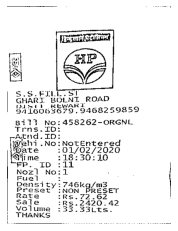

In [29]:
# конвертация в черно-белое с высоким контрастом для документов
from skimage.filters import threshold_local
# увеличить контраст в случае с документом
T = threshold_local(scanGray, 9, offset=8, method="gaussian")
scanBW = (scanGray > T).astype("uint8") * 255

plt.imshow(scanBW, cmap='gray')
plt.axis('off')
plt.show()